In this notebook we explore how to implement a quantum random walk using qiskit. We will compare the distribution of the final position of the quantum to the distribution of the final position of the classical random walk. 

In [25]:
!pip install qiskit

from IPython.display import clear_output
clear_output()

In [26]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit

Before we begin our discussion of quantum walks, let's revisit classical random walks. In a classical random walk, a particle is placed at the origin. A coin is flipped and if it lands heads, the particle will move one unit to the right, and if it lands on tails, the particle will move one unit to the left. After moving, the coin is flipped again, and the particle moves to the left or right according to the same rules as before. This process is then repeated a desired number of times. After all iterations of the process have completed, one can then look at the final position of the particle. It turns out that in the classical case, the distribution of the final position is given by the Gaussian distribution, but in the quantum case one can arrive at many exotic distributions which depend on the initial state of the system and on the type of "coin" that is used. 


In quantum walks, instead of using a classical where the coin is either heads or tails, we use a qubit that is in some superposition of the states $|0>$ and $|1>$. A common way to accomplish this superposition is initialize the coin qubit to $|0>$ and apply the Hadamard gate to produce $|+>$. This application of the Hadamard gate can be interpretted as a "quantum coin flip" (other unitaries besides the hadamard may be used and have varying effects on the distribution, but this is a discussion for later). And instead of shifting to the left or right, a state $|k>$ is sent to either $|k-1>$ or $|k+1>$ depending on the state of the coin. But if our coin is in some superposition of 0 and 1, then the state is $|k>$ is then "shifted" into some superposition of $|k-1>$ and $|k+1>$.  We then iterate this process, applying a Hadamard to the coin space and applying our shift operator to the state space. One can see quickly how the outcome of quantum walk might be significantly different from that of a classical walk due to the superposition that is not present in the classical case.

To implement this quantum walk, we need to figure out how to compute the shift operator. To construct the operator let's look at a couple of easy cases and see how they might extend. \\

If we have only one qubit in our state space, then shifting right should sned $|0>$ to $|1>$. But then what should $|1>$ get sent to? Since we only have one qubit, $|1>$ can't be sent to "$|2>$" since we only have two dimensions. But we need our shift operator to be unitary if want to be able to implement it in a quantum circuit. And since unitary operators must preserve orthonormality, the only possibility is to send $|1>$ to $|0>$. This causes our walk to "wrap around". And indeed this is what will happen when have more qubits to play with as well. Thus for one qubit, our "shift right" operator is given by $S_R =|0><1| + |0><1|$, or in matrix form 
$\begin{pmatrix}
0 & 1 \\
1 & 0 \\
\end{pmatrix}$. 

Now let's examine what happens with more qubits. Suppose we have two qubits in our state space. Then to shifting right should be the operator that does the following:

$|00> \mapsto |01>$ \\

$|01> \mapsto |10>$ \\

$|10> \mapsto |11>$ \\
Then we wrap around again and send $|11>$ to $|00>$. Writing this map as a matrix we see that the shift right operator can be written as 
$\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
\end{pmatrix}$

So it looks like that in both the 1 qubit and 2 qubit case, the shift right operator looks like a creation operator that's been truncated, and the highest energy level gets sent to the lowest. Indeed this pattern continues no matter how many qubit we use in our state space. 

Next, how do we go left? Well we just define the shift left operator to be the adjoint of the shift right operator i.e., we define $S_L = S_R^*$. This operator will send $|k>$ to $|k-1>$. 

Now that we've figured out a pattern, let's actually write some code to see how to construct this operator. 

The following code creates an $N\times N$ matrix $M$ with the entries $M_{i,i+1}=1$ for all $i$ between 0 and $N-2$, $M_{N-1,0}=1$, and all other entries are 0. So to implement the creation oeprator on $N$ qubits, we call the function "creation_operator(2**N)". 

In [27]:
#Create Shift Operator
 
def creation_operator(N):
  A = np.zeros((N,N))
  for i in range(N-1):
    A[i,i+1]=1
  A[N-1,0]=1
  return A

def creation_operator_gate(N):
  A = np.zeros((N,N))
  for i in range(N-1):
    A[i,i+1]=1
  A[N-1,0]=1
  return Operator(A)

Now that we implemented the creation operator, we need to use it to implement a controlled shift operator $CS$ where $CS$ applies the creation operator if the coin qubit is $|0>$, and applies the annihilation operator when the coin qubit is $|1>$. So in dirac noation, this operator can be expressed as 
$$CS = |0><0| \otimes S_R + |1><1|\otimes S_L $$

To implement this operator, we compute the projections onto the spaces spanned by $|0>$ and $|1>$ respectively and use numpy's built in kronecker product formula to tensor the projections with their corresponding shift operators. 

In [28]:
#Rank is N+1 x N+1 not NxN
def control_shift(N):
  A = creation_operator(N)
  proj0,proj1 = np.zeros((2,2)), np.zeros((2,2))
  proj0[0,0] ,proj1[1,1] = 1, 1
  CS = np.kron(proj0,A) + np.kron(proj1, np.transpose(A))
  CS = Operator(CS)
  return CS

We have now created all necessary operators for a quantum random walk and we're ready to put them all together to construct a circuit implementing the quantum random walk. The following function builds a circuit that peforms a quantum random walk on N qubits (not including the coin). I have an unused parameter called "coin" which would let the user decide what coin to use, but for now I have left out this portion of the code for next tutorial. A future tutorial may cover the affect the type of coin has on a quantum random walk, and I will include this feature.  

In [29]:
#Create random walk circuit
#Considers the origin to be (N+1//2,0) so that position states are less likely to wrap around. 
def quantum_random_walk(N,simulation_time,coin):
  #max simultation time without wrap around is 2**(N-1) 
  walk = QuantumCircuit(N+1)
  #shift origin to 2**(N-1)
  indices = [k+1 for k in range(N)]
  for k in range(2**(N-1)): #was N//2
    walk.append(creation_operator_gate(2**N),indices)

  #qubit 0 is the control qubit
  #h for hadamard coin
  CS = control_shift(2**N)
  if (coin == 'h'):
    for k in range(2**(N-1)):
      walk.h(0)
      walk.append(CS,range(N+1))
  return walk

In [30]:
#Uae 9 qubits for shifting left and right. And repeat the process 2**(M-1) times to ensure that no overlap happens. 
M=9
simulation_time = 2**(M-1)
coin = 'h'

In [31]:
#Build the circuit and run it on the simulator.
qc = QuantumCircuit(M,M)
qc.append(quantum_random_walk(M-1,simulation_time,'h'),range(M))
qc.measure(range(M),range(M))

In [32]:
#token hidden, connect to IBMQ


from qiskit import IBMQ
IBMQ.save_account(token)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

configrc.store_credentials:WARNING:2020-12-21 04:37:44,650: Credentials already present. Set overwrite=True to overwrite.
/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-12-21 04:37:45,524: Credentials are already in use. The existing account in the session will be replaced.


In [33]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, simulator).result().get_counts(qc)


In [34]:
#collecting data from simulation.
keys = counts.keys()
values = counts.values()

coin_bit = list(keys)[0][0] #might need later
#remove the coin bit, convert to decimal and shift back to the left
position =[]
for key in keys:
  position.append(int(key[1:],2)-128)

probabilities = list(values)

In [35]:
#implements the classical random walk
def walk_the_line(N,K,step,p):
  position=[]
  for n in range(N):
    X=0
    for k in range(K):
      coin = np.random.binomial(1,p)
      X=X-step*(-1)**coin
    position.append(X)
  
  return position

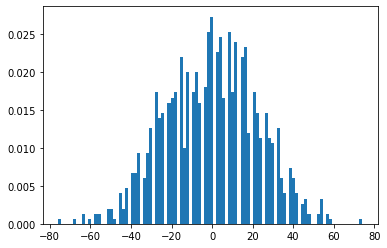

In [36]:
import matplotlib.pyplot as plt

#Distribution of a particle in a classical random walk. 
classical_positions = walk_the_line(1000,2**M,1,.5)
_ = plt.hist(classical_positions, density=True,bins=100,)

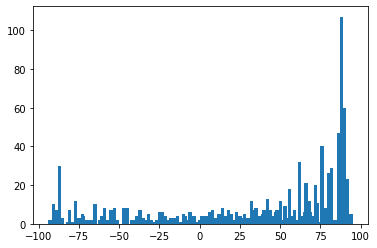

In [37]:
#Distribution of the final position of the particle in a quantum random walk. 
_ = plt.bar(position,probabilities,width=2)